### Visualize predictions from a model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
os.chdir('..')

In [3]:
!pwd

/home/hasib/masksup-recognition


In [12]:
import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pipeline.resnet_csra import ResNet_CSRA
from pipeline.vit_csra import VIT_B16_224_CSRA, VIT_L16_224_CSRA, VIT_CSRA
from pipeline.dataset import DataSet
from utils.evaluation.eval import evaluation
from utils.evaluation.eval import WarmUpLR
from utils.evaluation.eval import class_dict
from tqdm import tqdm

In [5]:
def Args():
    parser = argparse.ArgumentParser(description="settings")
    # model default resnet101
    parser.add_argument("--model", default="resnet101", type=str)
    parser.add_argument("--num_heads", default=1, type=int)
    parser.add_argument("--lam",default=0.1, type=float)
    parser.add_argument("--cutmix", default=None, type=str) # the path to load cutmix-pretrained backbone
    parser.add_argument("--load_from", default="models_local/resnet101_voc07_head1_lam0.1_94.7.pth", type=str)
    # dataset
    parser.add_argument("--dataset", default="voc07", type=str)
    parser.add_argument("--num_cls", default=20, type=int)
    parser.add_argument("--test_aug", default=[], type=list)
    parser.add_argument("--img_size", default=448, type=int)
    parser.add_argument("--batch_size", default=16, type=int)

    args = parser.parse_args("") # "" added because to work with jupyter notebooks
    return args



def val(args, model, test_loader, test_file):
    model.eval()
    print("Test on Pretrained Models")
    result_list = []

    # calculate logit
    for index, data in enumerate(tqdm(test_loader)):
        img = data['img'].cuda()
        target = data['target'].cuda()
        img_path = data['img_path']

        with torch.no_grad():
            logit = model(img)

        result = nn.Sigmoid()(logit).cpu().detach().numpy().tolist()
        for k in range(len(img_path)):
            result_list.append(
                {
                    "file_name": img_path[k].split("/")[-1].split(".")[0],
                    "scores": result[k]
                }
            )
    
    # cal_mAP OP OR
    evaluation(result=result_list, types=args.dataset, ann_path=test_file[0])

#### VOC 

Base

CUDA_VISIBLE_DEVICES=0 python train.py --exp_name base_rescm_voc --batch_size 6 --total_epoch 60 --num_heads 1 --lam 0.1 --dataset voc07 --num_cls 20 --cutmix data/resnet101_cutmix_pretrained.pth

MSL

CUDA_VISIBLE_DEVICES=0 python train_masksup.py --exp_name masksup_rescm_voc --batch_size 6 --total_epoch 60 --num_heads 1 --lam 0.1 --dataset voc07 --num_cls 20 --cutmix data/resnet101_cutmix_pretrained.pth

Test

CUDA_VISIBLE_DEVICES=0 python val.py --num_heads 1 --lam 0.1 --dataset voc07 --num_cls 20  --load_from checkpoint/voc_experiments/rescm_paper_voc/epoch_200.pth --cutmix data/resnet101_cutmix_pretrained.pth

In [6]:
args = Args()
args

Namespace(batch_size=16, cutmix=None, dataset='voc07', img_size=448, lam=0.1, load_from='models_local/resnet101_voc07_head1_lam0.1_94.7.pth', model='resnet101', num_cls=20, num_heads=1, test_aug=[])

### Set model path here

In [7]:
args.num_heads = 1
args.lam = 0.1
args.dataset = "voc07"
args.num_cls = 20
args.load_from = "checkpoint/voc_experiments/rescm_paper_voc_base/epoch_48.pth"
args.cutmix = "data/resnet101_cutmix_pretrained.pth"
args.batch_size = 1
args

Namespace(batch_size=1, cutmix='data/resnet101_cutmix_pretrained.pth', dataset='voc07', img_size=448, lam=0.1, load_from='checkpoint/voc_experiments/rescm_paper_voc_base/epoch_48.pth', model='resnet101', num_cls=20, num_heads=1, test_aug=[])

In [8]:
# model 
if args.model == "resnet101": 
    model = ResNet_CSRA(num_heads=args.num_heads, lam=args.lam, num_classes=args.num_cls, cutmix=args.cutmix)
if args.model == "vit_B16_224":
    model = VIT_B16_224_CSRA(cls_num_heads=args.num_heads, lam=args.lam, cls_num_cls=args.num_cls)
if args.model == "vit_L16_224":
    model = VIT_L16_224_CSRA(cls_num_heads=args.num_heads, lam=args.lam, cls_num_cls=args.num_cls)

model.cuda()


print("Loading weights from {}".format(args.load_from))
if torch.cuda.device_count() > 1:
    print("lets use {} GPUs.".format(torch.cuda.device_count()))
    model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model.module.load_state_dict(torch.load(args.load_from))
else:
    model.load_state_dict(torch.load(args.load_from))

# data
if args.dataset == "voc07":
    test_file = ['data/voc07/test_voc07.json']
if args.dataset == "coco":
    test_file = ['data/coco/val_coco2014.json']
if args.dataset == "wider":
    test_file = ['data/wider/test_wider.json']


test_dataset = DataSet(test_file, args.test_aug, args.img_size, args.dataset)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

val(args, model, test_loader, test_file) # this should match value in spreadsheet

backbone params inited by CutMix pretrained model
Loading weights from checkpoint/voc_experiments/rescm_paper_voc_base/epoch_48.pth
Compose(
    Resize(size=(448, 448), interpolation=bilinear)
)
Test on Pretrained Models


100%|██████████| 4952/4952 [00:53<00:00, 92.64it/s] 


Evaluation


100%|██████████| 20/20 [00:00<00:00, 504.93it/s]

mAP: 0.937091
CP: 0.892378, CR: 0.875727, CF1 :0.883974
OP: 0.921123, OR: 0.889206, OF1 0.904883


### Visualize predictions

In [55]:
# Helpers

# Font Size
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 30}

import torch 

import numpy as np 
import matplotlib.pyplot as plt

# def to_img(ten):
#     ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
#     ten=(ten*255).astype(np.uint8)
#     return ten

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def to_img_(ten):
    curr_img = ten.detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0, 0, 0]), # mean and std
                           torch.tensor([1, 1, 1])) 
    curr_img = curr_img.permute((1, 2, 0))
    return curr_img

# a = to_img_(img[7])
# print(a.shape)
# plt.imshow(a)

# n_images = 5

# fig, axes = plt.subplots(nrows=1, ncols=n_images, 
#                          sharex=True, sharey=True, figsize=(20, 2.5))

# for i in range(5):
#     axes[i].imshow(to_img_(img[i]))

In [46]:
model.eval() 

data = next(iter(test_loader))

# Load data
img = data["img"].cuda()
img_path = data["img_path"]
target = data["target"].cuda()

# Predict
logit = model(img).squeeze(0)
logit = nn.Sigmoid()(logit)

# Get class names from predictions
pos = torch.where(logit > 0.5)[0].cpu().numpy()
predictions = []
for k in pos:
    predictions.append(class_dict[args.dataset][k])

# Get class names from labels
post = torch.where(target[0]  > 0.5)[0].cpu().numpy()
gts = []
for k in pos:
    gts.append(class_dict[args.dataset][k])

print(predictions, gts)

['dog', 'person'] ['dog', 'person']


In [71]:
caption = str(predictions)[1:-1]
caption

"'dog', 'person'"

In [72]:
# todo
# make folder and save images in them (folder should have similar name as saved model)
# compare gt and pred, if correct label in green, if wrong, label in red

Text(0.5, 0.05, "'dog', 'person'")

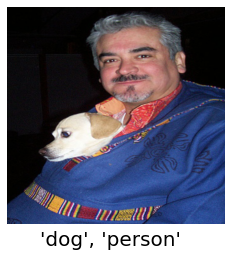

In [73]:
fig = plt.figure()
plt.imshow(to_img_(img[0]))
plt.axis("off")
fig.text(.5, .05, caption, ha='center', size=20)

In [63]:
# plt.savefig("../logs/visualization/masks.pdf", facecolor="white", bbox_inches = 'tight', dpi=300)

In [ ]:
model.eval()
result_list = []

# calculate logit
for index, data in enumerate(tqdm(test_loader)):
    img = data['img'].cuda()
    target = data['target'].cuda()
    img_path = data['img_path']

    with torch.no_grad():
        logit = model(img)

    
    # result = nn.Sigmoid()(logit).cpu().detach().numpy().tolist()
    # for k in range(len(img_path)):
    #     result_list.append(
    #         {
    #             "file_name": img_path[k].split("/")[-1].split(".")[0],
    #             "scores": result[k]
    #         }
    #     )